In [1]:
import sqlite3

In [81]:
import pandas as pd
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt

to preface, the data given currently has the 500 cities data "df500" (health information for each tract and fips id),
the access data from the food atlas "food_atlas" (access variable measures for each county), variable list "var_list"(information about the variables and how they are measured like count vs percentage), and I will also add the 500 cities tract shape files for graphing in maps as a gpd file "tracts"


**We will start with loading the data, understanding the datasets, and cleaning/merging as needed**

In [3]:
conn = sqlite3.connect("challenge.db")


In [45]:
schema = pd.read_sql("SELECT name FROM sqlite_master WHERE type='table';", conn)
schema

,name
0,five_hundred_cities
1,access
2,variable_list


In [5]:
df500 = pd.read_sql("SELECT * FROM five_hundred_cities;", conn)

In [42]:
df500.head()

,index,StateAbbr,PlaceName,PlaceFIPS,TractFIPS,Place_TractID,Population2010,ACCESS2_CrudePrev,ACCESS2_Crude95CI,ARTHRITIS_CrudePrev,...,PAPTEST_Crude95CI,PHLTH_CrudePrev,PHLTH_Crude95CI,SLEEP_CrudePrev,SLEEP_Crude95CI,STROKE_CrudePrev,STROKE_Crude95CI,TEETHLOST_CrudePrev,TEETHLOST_Crude95CI,Geolocation
0,0,AL,Birmingham,107000,1073000100,0107000-01073000100,3042,24.4,"(21.2, 27.8)",31.2,...,"(83.4, 86.6)",20.5,"(18.9, 22.2)",45.5,"(44.3, 46.5)",5.5,"( 5.0, 5.9)",28.9,"(23.7, 35.1)","(33.57943283260, -86.7228323926)"
1,1,AL,Birmingham,107000,1073000300,0107000-01073000300,2735,30.4,"(27.1, 33.7)",30.5,...,"(81.9, 85.6)",22.2,"(20.4, 24.0)",44.5,"(43.2, 45.7)",6.1,"( 5.5, 6.8)",32.9,"(25.5, 40.2)","(33.54282086860, -86.7524339780)"
2,2,AL,Birmingham,107000,1073000400,0107000-01073000400,3338,24.7,"(21.1, 28.5)",31.5,...,"(82.3, 86.8)",19.4,"(17.5, 21.4)",45.7,"(44.2, 47.0)",5.6,"( 5.0, 6.2)",28.6,"(22.0, 35.1)","(33.56324496330, -86.7640474064)"
3,3,AL,Birmingham,107000,1073000500,0107000-01073000500,2864,25.2,"(21.6, 29.0)",35.0,...,"(82.1, 86.5)",21.7,"(19.7, 23.9)",46.1,"(44.5, 47.4)",7.3,"( 6.5, 8.2)",34.0,"(24.4, 42.9)","(33.54424045940, -86.7749130719)"
4,4,AL,Birmingham,107000,1073000700,0107000-01073000700,2577,29.0,"(24.5, 33.8)",36.3,...,"(82.2, 87.1)",25.5,"(23.1, 28.0)",48.3,"(46.6, 49.7)",9.0,"( 8.1, 10.0)",43.2,"(33.2, 53.2)","(33.55254061390, -86.8016893706)"


The place fips has normally 7 digits, here it has 6 due to a missing leading 0. Add leading 0, then cut it to 5 digits

In [177]:
df500.columns

Index(['index', 'StateAbbr', 'PlaceName', 'PlaceFIPS', 'TractFIPS',
       'Place_TractID', 'Population2010', 'ACCESS2_CrudePrev',
       'ACCESS2_Crude95CI', 'ARTHRITIS_CrudePrev', 'ARTHRITIS_Crude95CI',
       'BINGE_CrudePrev', 'BINGE_Crude95CI', 'BPHIGH_CrudePrev',
       'BPHIGH_Crude95CI', 'BPMED_CrudePrev', 'BPMED_Crude95CI',
       'CANCER_CrudePrev', 'CANCER_Crude95CI', 'CASTHMA_CrudePrev',
       'CASTHMA_Crude95CI', 'CHD_CrudePrev', 'CHD_Crude95CI',
       'CHECKUP_CrudePrev', 'CHECKUP_Crude95CI', 'CHOLSCREEN_CrudePrev',
       'CHOLSCREEN_Crude95CI', 'COLON_SCREEN_CrudePrev',
       'COLON_SCREEN_Crude95CI', 'COPD_CrudePrev', 'COPD_Crude95CI',
       'COREM_CrudePrev', 'COREM_Crude95CI', 'COREW_CrudePrev',
       'COREW_Crude95CI', 'CSMOKING_CrudePrev', 'CSMOKING_Crude95CI',
       'DENTAL_CrudePrev', 'DENTAL_Crude95CI', 'DIABETES_CrudePrev',
       'DIABETES_Crude95CI', 'HIGHCHOL_CrudePrev', 'HIGHCHOL_Crude95CI',
       'KIDNEY_CrudePrev', 'KIDNEY_Crude95CI', 'LPA_CrudePre

In [7]:
food_atlas = pd.read_sql("SELECT * FROM access;", conn)

In [72]:
food_atlas

,index,FIPS,State,County,LACCESS_POP10,LACCESS_POP15,PCH_LACCESS_POP_10_15,PCT_LACCESS_POP10,PCT_LACCESS_POP15,LACCESS_LOWI10,...,PCT_LACCESS_HISP15,LACCESS_NHASIAN15,PCT_LACCESS_NHASIAN15,LACCESS_NHNA15,PCT_LACCESS_NHNA15,LACCESS_NHPI15,PCT_LACCESS_NHPI15,LACCESS_MULTIR15,PCT_LACCESS_MULTIR15,county_fips
0,0,1001,AL,Autauga,18428.439685,17496.693038,-5.056026,33.769657,32.062255,5344.427472,...,0.863345,86.767975,0.159000,61.169869,0.112092,8.817961,0.016159,482.848633,0.884808,01001
1,1,1003,AL,Baldwin,35210.814078,30561.264430,-13.204891,19.318473,16.767489,9952.144027,...,0.755973,212.946378,0.116833,181.649648,0.099662,14.819634,0.008131,1127.696098,0.618712,01003
2,2,1005,AL,Barbour,5722.305602,6069.523628,6.067799,20.840972,22.105560,3135.676086,...,1.855183,17.096410,0.062266,39.960527,0.145539,8.082376,0.029436,462.382655,1.684025,01005
3,3,1007,AL,Bibb,1044.867327,969.378841,-7.224696,4.559753,4.230324,491.449066,...,0.037516,1.994318,0.008703,2.513097,0.010967,0.000000,0.000000,5.259244,0.022951,01007
4,4,1009,AL,Blount,1548.175559,3724.428242,140.568857,2.700840,6.497380,609.027708,...,0.867886,8.428994,0.014705,28.938242,0.050484,1.062851,0.001854,202.914187,0.353990,01009
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3138,3138,56037,WY,Sweetwater,13391.715505,18934.737809,41.391428,30.570505,43.224074,2414.618816,...,6.075311,114.722086,0.261887,189.621441,0.432866,27.720443,0.063280,1605.391465,3.664775,56037
3139,3139,56039,WY,Teton,6212.423697,6212.390430,-0.000535,29.174527,29.174370,1059.463554,...,3.457192,53.489780,0.251196,32.482255,0.152542,8.468847,0.039771,460.434464,2.162273,56039
3140,3140,56041,WY,Uinta,4270.147119,4686.017653,9.739021,20.220414,22.189685,1518.415783,...,2.536304,13.831709,0.065497,40.339658,0.191020,6.586104,0.031187,350.320469,1.658871,56041
3141,3141,56043,WY,Washakie,931.411647,931.411647,0.000000,10.915407,10.915407,233.628356,...,0.415733,6.366775,0.074614,5.006976,0.058678,0.000000,0.000000,34.160542,0.400334,56043


notice here that the fips codes are 4 digits, not the nromal 5 for county fips. This is due to a missing leading 0 which we can add in when combining the datasets

In [57]:
df500["TractFIPS"] = (
    df500["TractFIPS"]
    .astype(str)
    .str.zfill(11)
)

In [64]:
df500["PlaceFIPS"] = (
    df500["PlaceFIPS"]
    .astype(str)
    .str.zfill(7)
)

In [65]:
df500["TractFIPS"].str.len().value_counts()


TractFIPS
11    27210
Name: count, dtype: int64

In [62]:
df500["county_fips"] = df500["TractFIPS"].str[:5]

In [67]:
df500["PlaceFIPS"].str.len().value_counts()

PlaceFIPS
7    27210
Name: count, dtype: int64

In [71]:
df500

,index,StateAbbr,PlaceName,PlaceFIPS,TractFIPS,Place_TractID,Population2010,ACCESS2_CrudePrev,ACCESS2_Crude95CI,ARTHRITIS_CrudePrev,...,PHLTH_CrudePrev,PHLTH_Crude95CI,SLEEP_CrudePrev,SLEEP_Crude95CI,STROKE_CrudePrev,STROKE_Crude95CI,TEETHLOST_CrudePrev,TEETHLOST_Crude95CI,Geolocation,county_fips
0,0,AL,Birmingham,0107000,01073000100,0107000-01073000100,3042,24.4,"(21.2, 27.8)",31.2,...,20.5,"(18.9, 22.2)",45.5,"(44.3, 46.5)",5.5,"( 5.0, 5.9)",28.9,"(23.7, 35.1)","(33.57943283260, -86.7228323926)",01073
1,1,AL,Birmingham,0107000,01073000300,0107000-01073000300,2735,30.4,"(27.1, 33.7)",30.5,...,22.2,"(20.4, 24.0)",44.5,"(43.2, 45.7)",6.1,"( 5.5, 6.8)",32.9,"(25.5, 40.2)","(33.54282086860, -86.7524339780)",01073
2,2,AL,Birmingham,0107000,01073000400,0107000-01073000400,3338,24.7,"(21.1, 28.5)",31.5,...,19.4,"(17.5, 21.4)",45.7,"(44.2, 47.0)",5.6,"( 5.0, 6.2)",28.6,"(22.0, 35.1)","(33.56324496330, -86.7640474064)",01073
3,3,AL,Birmingham,0107000,01073000500,0107000-01073000500,2864,25.2,"(21.6, 29.0)",35.0,...,21.7,"(19.7, 23.9)",46.1,"(44.5, 47.4)",7.3,"( 6.5, 8.2)",34.0,"(24.4, 42.9)","(33.54424045940, -86.7749130719)",01073
4,4,AL,Birmingham,0107000,01073000700,0107000-01073000700,2577,29.0,"(24.5, 33.8)",36.3,...,25.5,"(23.1, 28.0)",48.3,"(46.6, 49.7)",9.0,"( 8.1, 10.0)",43.2,"(33.2, 53.2)","(33.55254061390, -86.8016893706)",01073
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27205,27205,WY,Cheyenne,5613900,56021001000,5613900-56021001000,3026,17.2,"(14.9, 19.9)",24.2,...,12.2,"(11.1, 13.4)",34.5,"(33.0, 35.8)",3.0,"( 2.8, 3.3)",16.2,"(11.4, 21.5)","(41.14141598330, -104.829095061)",56021
27206,27206,WY,Cheyenne,5613900,56021001200,5613900-56021001200,4638,9.8,"( 7.8, 12.0)",25.2,...,8.8,"( 7.6, 10.1)",29.0,"(27.5, 30.7)",2.5,"( 2.2, 2.8)",8.1,"( 4.7, 12.2)","(41.17926735060, -104.838572685)",56021
27207,27207,WY,Cheyenne,5613900,56021001501,5613900-56021001501,3312,14.5,"(12.9, 16.1)",22.0,...,9.6,"( 8.9, 10.4)",32.9,"(31.9, 33.9)",2.3,"( 2.2, 2.5)",11.9,"( 8.5, 15.9)","(41.16037417080, -104.756560525)",56021
27208,27208,WY,Cheyenne,5613900,56021001502,5613900-56021001502,4518,16.6,"(14.3, 18.9)",25.2,...,12.0,"(10.8, 13.3)",34.8,"(33.3, 36.1)",3.2,"( 2.8, 3.6)",19.7,"(13.1, 27.1)","(41.15063392830, -104.755675636)",56021


In [9]:
var_list = pd.read_sql("SELECT * FROM variable_list;", conn)

,index,Category Name,Category Code,Subcategory Name,Variable Name,Variable Code,Geography,Units
0,0,Access and Proximity to Grocery Store,ACCESS,Overall,"Population, low access to store, 2010",LACCESS_POP10,CNTY10,Count
1,1,Access and Proximity to Grocery Store,ACCESS,Overall,"Population, low access to store, 2015",LACCESS_POP15,CNTY10,Count
2,2,Access and Proximity to Grocery Store,ACCESS,Overall,"Population, low access to store (% change), 20...",PCH_LACCESS_POP_10_15,CNTY10,% change
3,3,Access and Proximity to Grocery Store,ACCESS,Overall,"Population, low access to store (%), 2010",PCT_LACCESS_POP10,CNTY10,Percent
4,4,Access and Proximity to Grocery Store,ACCESS,Overall,"Population, low access to store (%), 2015",PCT_LACCESS_POP15,CNTY10,Percent
...,...,...,...,...,...,...,...,...
276,276,Socioeconomic Characteristics,SOCIOECONOMIC,Income Level,"Persistent-poverty counties, 2010",PERPOV10,CNTY10,Legend
277,277,Socioeconomic Characteristics,SOCIOECONOMIC,Income Level,"Child poverty rate, 2015",CHILDPOVRATE15,CNTY10,Percent
278,278,Socioeconomic Characteristics,SOCIOECONOMIC,Income Level,"Persistent-child-poverty counties, 2010",PERCHLDPOV10,CNTY10,Legend
279,279,Socioeconomic Characteristics,SOCIOECONOMIC,Other,"Metro/nonmetro counties, 2010",METRO13,CNTY10,Legend


In [35]:
print(df500.shape)
print(food_atlas.shape)
print(var_list.shape)

(27210, 64)
(3143, 45)
(281, 8)


In [33]:
#df500.info()

In [32]:
#food_atlas.info()

In [30]:
#var_list.info()

In [52]:
#add leading 0s to the fips codes 
food_atlas["county_fips"] = (food_atlas["FIPS"].astype(str).str.zfill(5))

In [182]:
food_atlas.head()

,index,FIPS,State,County,LACCESS_POP10,LACCESS_POP15,PCH_LACCESS_POP_10_15,PCT_LACCESS_POP10,PCT_LACCESS_POP15,LACCESS_LOWI10,...,PCT_LACCESS_HISP15,LACCESS_NHASIAN15,PCT_LACCESS_NHASIAN15,LACCESS_NHNA15,PCT_LACCESS_NHNA15,LACCESS_NHPI15,PCT_LACCESS_NHPI15,LACCESS_MULTIR15,PCT_LACCESS_MULTIR15,county_fips
0,0,1001,AL,Autauga,18428.439685,17496.693038,-5.056026,33.769657,32.062255,5344.427472,...,0.863345,86.767975,0.159000,61.169869,0.112092,8.817961,0.016159,482.848633,0.884808,01001
1,1,1003,AL,Baldwin,35210.814078,30561.264430,-13.204891,19.318473,16.767489,9952.144027,...,0.755973,212.946378,0.116833,181.649648,0.099662,14.819634,0.008131,1127.696098,0.618712,01003
2,2,1005,AL,Barbour,5722.305602,6069.523628,6.067799,20.840972,22.105560,3135.676086,...,1.855183,17.096410,0.062266,39.960527,0.145539,8.082376,0.029436,462.382655,1.684025,01005
3,3,1007,AL,Bibb,1044.867327,969.378841,-7.224696,4.559753,4.230324,491.449066,...,0.037516,1.994318,0.008703,2.513097,0.010967,0.000000,0.000000,5.259244,0.022951,01007
4,4,1009,AL,Blount,1548.175559,3724.428242,140.568857,2.700840,6.497380,609.027708,...,0.867886,8.428994,0.014705,28.938242,0.050484,1.062851,0.001854,202.914187,0.353990,01009


In [179]:
food_atlas.columns

Index(['index', 'FIPS', 'State', 'County', 'LACCESS_POP10', 'LACCESS_POP15',
       'PCH_LACCESS_POP_10_15', 'PCT_LACCESS_POP10', 'PCT_LACCESS_POP15',
       'LACCESS_LOWI10', 'LACCESS_LOWI15', 'PCH_LACCESS_LOWI_10_15',
       'PCT_LACCESS_LOWI10', 'PCT_LACCESS_LOWI15', 'LACCESS_HHNV10',
       'LACCESS_HHNV15', 'PCH_LACCESS_HHNV_10_15', 'PCT_LACCESS_HHNV10',
       'PCT_LACCESS_HHNV15', 'LACCESS_SNAP15', 'PCT_LACCESS_SNAP15',
       'LACCESS_CHILD10', 'LACCESS_CHILD15', 'LACCESS_CHILD_10_15',
       'PCT_LACCESS_CHILD10', 'PCT_LACCESS_CHILD15', 'LACCESS_SENIORS10',
       'LACCESS_SENIORS15', 'PCH_LACCESS_SENIORS_10_15',
       'PCT_LACCESS_SENIORS10', 'PCT_LACCESS_SENIORS15', 'LACCESS_WHITE15',
       'PCT_LACCESS_WHITE15', 'LACCESS_BLACK15', 'PCT_LACCESS_BLACK15',
       'LACCESS_HISP15', 'PCT_LACCESS_HISP15', 'LACCESS_NHASIAN15',
       'PCT_LACCESS_NHASIAN15', 'LACCESS_NHNA15', 'PCT_LACCESS_NHNA15',
       'LACCESS_NHPI15', 'PCT_LACCESS_NHPI15', 'LACCESS_MULTIR15',
       'PCT_LAC

In [184]:
access_cols = [
    'county_fips', 'index', 'FIPS', 'State', 'County',

    # Counts
    'LACCESS_POP15', 'LACCESS_CHILD15', 'LACCESS_SENIORS15',
    'LACCESS_LOWI15', 'LACCESS_HHNV15', 'LACCESS_SNAP15',
    'LACCESS_BLACK15', 'LACCESS_WHITE15', 'LACCESS_HISP15',
    'LACCESS_NHASIAN15', 'LACCESS_NHNA15', 'LACCESS_NHPI15',
    'LACCESS_MULTIR15',

    # Percents
    'PCT_LACCESS_POP15', 'PCT_LACCESS_CHILD15', 'PCT_LACCESS_SENIORS15',
    'PCT_LACCESS_LOWI15', 'PCT_LACCESS_HHNV15', 'PCT_LACCESS_SNAP15',
    'PCT_LACCESS_BLACK15', 'PCT_LACCESS_WHITE15', 'PCT_LACCESS_HISP15',
    'PCT_LACCESS_NHASIAN15', 'PCT_LACCESS_NHNA15',
    'PCT_LACCESS_NHPI15', 'PCT_LACCESS_MULTIR15'
]

food = food_atlas[access_cols].copy()


going to do a left merge onto the city dataset since it is at tract level and food atlas is at county level, and each county has multiple tracts so we can assign many city values(tracts) to one food atlas value(county)


In [69]:
city_and_atlas = df500.merge(
    food_atlas,
    on="county_fips",
    how="left",
    validate="many_to_one"
)

In [180]:
id_cols = ['index', 'FIPS', 'State', 'County']
food_vars = [c for c in food_atlas.columns if c not in id_cols]

matched_vars = var_list[
    var_list['Variable Code'].isin(food_vars)
]

filtered_vars = matched_vars[
    matched_vars['Variable Code'].str.endswith('15') &
    matched_vars['Units'].str.contains('Count|Percent', case=False, na=False)
]

filtered_vars[
    ['Variable Code', 'Variable Name', 'Category Name', 'Category Code', 'Units']
].sort_values(['Category Name', 'Variable Code'])


,Variable Code,Variable Name,Category Name,Category Code,Units
29,LACCESS_BLACK15,"Black, low access to store, 2015",Access and Proximity to Grocery Store,ACCESS,Count
18,LACCESS_CHILD15,"Children, low access to store, 2015",Access and Proximity to Grocery Store,ACCESS,Count
11,LACCESS_HHNV15,"Households, no car & low access to store, 2015",Access and Proximity to Grocery Store,ACCESS,Count
31,LACCESS_HISP15,"Hispanic ethnicity, low access to store, 2015",Access and Proximity to Grocery Store,ACCESS,Count
6,LACCESS_LOWI15,"Low income & low access to store, 2015",Access and Proximity to Grocery Store,ACCESS,Count
39,LACCESS_MULTIR15,"Multiracial, low access to store, 2015",Access and Proximity to Grocery Store,ACCESS,Count
33,LACCESS_NHASIAN15,"Asian, low access to store, 2015",Access and Proximity to Grocery Store,ACCESS,Count
35,LACCESS_NHNA15,"American Indian or Alaska Native, low access t...",Access and Proximity to Grocery Store,ACCESS,Count
37,LACCESS_NHPI15,"Hawaiian or Pacific Islander, low access to st...",Access and Proximity to Grocery Store,ACCESS,Count
1,LACCESS_POP15,"Population, low access to store, 2015",Access and Proximity to Grocery Store,ACCESS,Count


In [181]:
selected_variable_codes = (
    filtered_vars['Variable Code']
    .sort_values()
    .unique()
    .tolist()
)

selected_variable_codes


['LACCESS_BLACK15',
 'LACCESS_CHILD15',
 'LACCESS_HHNV15',
 'LACCESS_HISP15',
 'LACCESS_LOWI15',
 'LACCESS_MULTIR15',
 'LACCESS_NHASIAN15',
 'LACCESS_NHNA15',
 'LACCESS_NHPI15',
 'LACCESS_POP15',
 'LACCESS_SENIORS15',
 'LACCESS_SNAP15',
 'LACCESS_WHITE15',
 'PCT_LACCESS_BLACK15',
 'PCT_LACCESS_CHILD15',
 'PCT_LACCESS_HHNV15',
 'PCT_LACCESS_HISP15',
 'PCT_LACCESS_LOWI15',
 'PCT_LACCESS_MULTIR15',
 'PCT_LACCESS_NHASIAN15',
 'PCT_LACCESS_NHNA15',
 'PCT_LACCESS_NHPI15',
 'PCT_LACCESS_POP15',
 'PCT_LACCESS_SENIORS15',
 'PCT_LACCESS_SNAP15',
 'PCT_LACCESS_WHITE15']

In [79]:
city_and_atlas.columns

Index(['index_x', 'StateAbbr', 'PlaceName', 'PlaceFIPS', 'TractFIPS',
       'Place_TractID', 'Population2010', 'ACCESS2_CrudePrev',
       'ACCESS2_Crude95CI', 'ARTHRITIS_CrudePrev',
       ...
       'LACCESS_HISP15', 'PCT_LACCESS_HISP15', 'LACCESS_NHASIAN15',
       'PCT_LACCESS_NHASIAN15', 'LACCESS_NHNA15', 'PCT_LACCESS_NHNA15',
       'LACCESS_NHPI15', 'PCT_LACCESS_NHPI15', 'LACCESS_MULTIR15',
       'PCT_LACCESS_MULTIR15'],
      dtype='object', length=110)

We now have tract level df with the geo labels and IDs are given with StateAbbr PlaceName and TractFIPS
Now that there are around 110 variables, we can look at nutrition sensitive health variables to keep.
Also need to decide how to deal with percentage vs counts

Based off of the question at hand, we have chosen health indicators that are nutrition dependent, as well as access indicators to target different subpopulations.

Health indicators = PHLTH_CrudePrev, STROKE_CrudePrev, OBESITY_CrudePrev, HIGHCHOL_CrudePrev, DIABETES_CrudePrev, CHOLSCREEN_CrudePrev, CHD_CrudePrev, BPMED_CrudePrev, BPHIGH_CrudePrev (all number vars) 

access labels = LACCESS_POP10, LACCESS_SENIORS10, LACCESS_LOWI10, LACCESS_HHNV10, LACCESS_CHILD10 and corresponding percentages for the access intensity. counts will be for population burden/scale

**Here we have also read in the .shp files and loaded them into geopandas**

In [38]:
tracts = gpd.read_file("500Cities_Tracts/500Cities_Tracts_Clip.shp")
tracts.head()

,place2010,tract2010,ST,PlaceName,plctract10,PlcTrPop10,geometry
0,0107000,01073000100,01,Birmingham,0107000-01073000100,3042,"POLYGON ((-9653001.056 3974630.899, -9652982.0..."
1,0107000,01073000300,01,Birmingham,0107000-01073000300,2735,"POLYGON ((-9657462.853 3968794.996, -9657470.2..."
2,0107000,01073000400,01,Birmingham,0107000-01073000400,3338,"POLYGON ((-9657275.613 3972217.16, -9657275.39..."
3,0107000,01073000500,01,Birmingham,0107000-01073000500,2864,"POLYGON ((-9660666.406 3968887.964, -9660631.7..."
4,0107000,01073000700,01,Birmingham,0107000-01073000700,2577,"POLYGON ((-9661391.097 3968591.429, -9661398.2..."


In [156]:
tracts.crs
tracts.columns
tracts.shape

(29305, 7)

**From here we will:**
1. create a new dataset with only the variables we chose to look at
2. Further reduce redundancy with correlation and select the more affected subgroups to focus on
3. Standardize health and food access variables to create priority indeces
4. sum counts to estimate population impact
5. run subgroup ID using k-means or EN
6. merge with tracts and make maps

   


In [86]:
health_vars = [
    'PHLTH_CrudePrev','STROKE_CrudePrev','OBESITY_CrudePrev','HIGHCHOL_CrudePrev',
    'DIABETES_CrudePrev','CHOLSCREEN_CrudePrev','CHD_CrudePrev','BPMED_CrudePrev','BPHIGH_CrudePrev']


id_vars = ['TractFIPS','PlaceFIPS','State','PlaceName','Population2010', 'county_fips']

In [87]:
candidate_vars = id_vars + health_vars + food_pct_vars + food_count_vars

In [88]:
df_candidate = city_and_atlas[candidate_vars].copy()

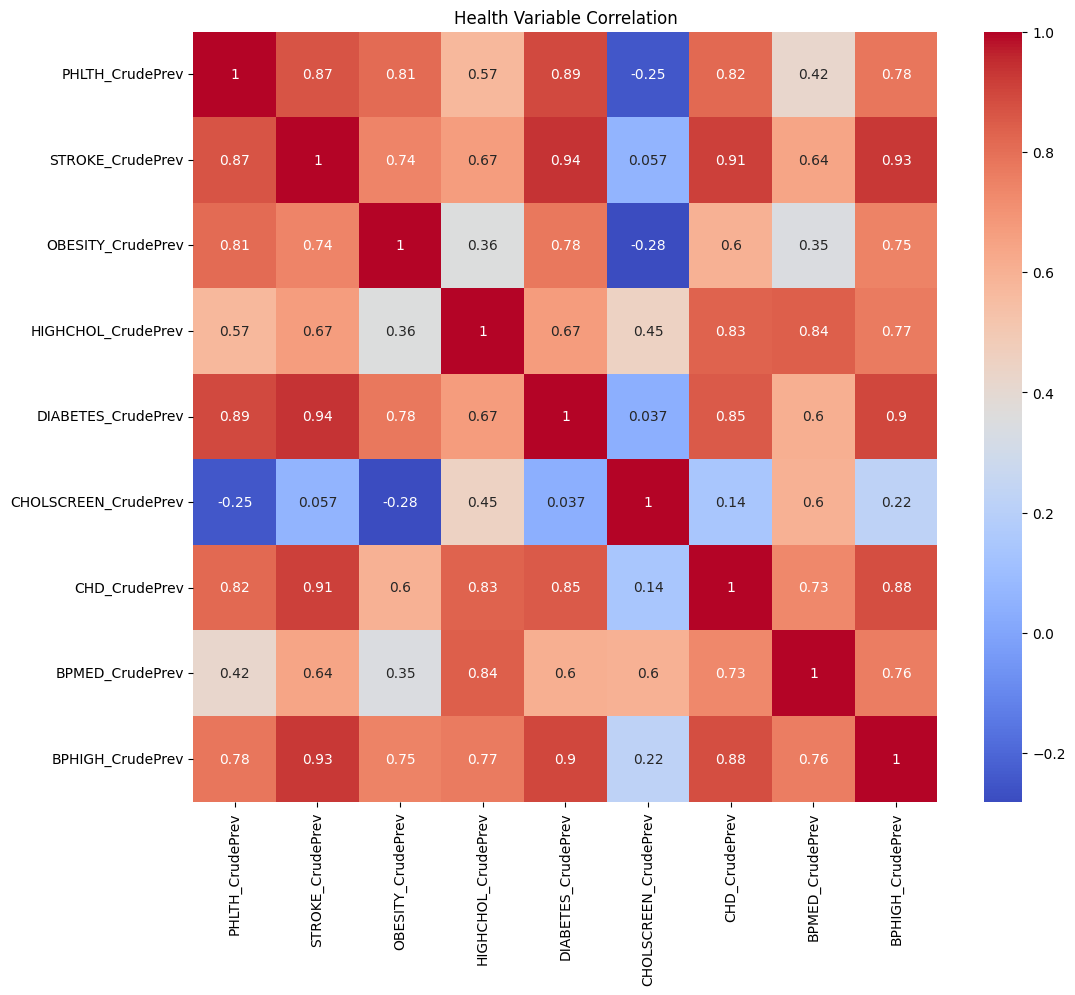

In [89]:
plt.figure(figsize=(12,10))
sns.heatmap(df_candidate[health_vars].corr(), annot=True, cmap='coolwarm')
plt.title("Health Variable Correlation")
plt.show()

Thinking of removing BPMED and CHOLSCREEN because those are preventative and addressing methods, not statistics of measure. I am going to use r<|0.85| as a high correlation threshold. Here, we see stroke and diabetes have a strong correlation, stroke and high bp have a high correlation, stroke and chronic heart disease have a high correlation, high plth and diabetes correlation, high plth and stroke correlation, high diabetes and bp correlation, high diabetes and chd correlation, high chd and bp correlation, high chd and diabetes correlation, high chd and stroke correlation. We can see clusters of correlated variables, where stroke, chd, and high bp are correlated, diabetes, obesity, and high bp are correlated, phlth, diabetes, and stroke are highly correlated

Looks here like we can definitely drop the cholscreen and bpmed (as they can also be driven by healthcare access and insurance coverage) from health variables, but we want to track all population subgroups so we won't drop those subgroups.

we will keep these:
'PHLTH_CrudePrev', 'OBESITY_CrudePrev',
       'HIGHCHOL_CrudePrev', 'DIABETES_CrudePrev', 'BPHIGH_CrudePrev'

In [183]:
df_candidate

,TractFIPS,PlaceFIPS,State,PlaceName,Population2010,county_fips,PHLTH_CrudePrev,OBESITY_CrudePrev,HIGHCHOL_CrudePrev,DIABETES_CrudePrev,...,priority_index_seniors,priority_index_low_income,priority_index_children,priority_index_no_vehicle,impact_score_overall,impact_score_seniors,impact_score_low_income,impact_score_children,impact_score_no_vehicle,deploy_flag
0,01073000100,0107000,AL,Birmingham,3042,01073,20.5,46.4,35.3,17.4,...,3.178935,3.378339,2.860298,3.714293,97.447362,12.962862,38.587363,21.814533,10.623316,True
1,01073000300,0107000,AL,Birmingham,2735,01073,22.2,47.8,36.8,19.8,...,3.483853,3.683257,3.165216,4.019211,107.137701,14.206237,42.070134,24.140041,11.495417,True
2,01073000400,0107000,AL,Birmingham,3338,01073,19.4,45.7,35.6,18.4,...,3.199991,3.399396,2.881354,3.735349,98.116544,13.048725,38.827871,21.975125,10.683540,True
3,01073000500,0107000,AL,Birmingham,2864,01073,21.7,48.0,38.4,22.4,...,3.793941,3.993345,3.475304,4.329299,116.992346,15.470695,45.611958,26.504979,12.382306,True
4,01073000700,0107000,AL,Birmingham,2577,01073,25.5,52.7,39.0,25.0,...,4.302790,4.502195,3.984154,4.838148,133.163659,17.545650,51.424033,30.385804,13.837675,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27205,56021001000,5613900,WY,Cheyenne,3026,56021,12.2,31.7,31.6,9.7,...,0.311601,0.239564,0.722090,-0.522375,15.199654,0.783573,1.417802,4.620191,-0.364520,False
27206,56021001200,5613900,WY,Cheyenne,4638,56021,8.8,25.4,32.9,8.1,...,-0.043392,-0.115429,0.367096,-0.877369,6.646921,-0.109117,-0.683140,2.348812,-0.612239,False
27207,56021001501,5613900,WY,Cheyenne,3312,56021,9.6,27.7,29.1,7.4,...,-0.215479,-0.287516,0.195010,-1.049455,2.500913,-0.541856,-1.701588,1.247742,-0.732323,False
27208,56021001502,5613900,WY,Cheyenne,4518,56021,12.0,30.9,31.9,9.4,...,0.289979,0.217942,0.700467,-0.543997,14.678712,0.729199,1.289835,4.481842,-0.379608,False


In [94]:
cols_to_drop = [
    'STROKE_CrudePrev',
    'CHOLSCREEN_CrudePrev',
    'CHD_CrudePrev',
    'BPMED_CrudePrev'
]

df_candidate = df_candidate.drop(columns=cols_to_drop, errors='ignore')

In [95]:
df_candidate

,TractFIPS,PlaceFIPS,State,PlaceName,Population2010,county_fips,PHLTH_CrudePrev,OBESITY_CrudePrev,HIGHCHOL_CrudePrev,DIABETES_CrudePrev,...,PCT_LACCESS_POP10,PCT_LACCESS_SENIORS10,PCT_LACCESS_LOWI10,PCT_LACCESS_HHNV10,PCT_LACCESS_CHILD10,LACCESS_POP10,LACCESS_SENIORS10,LACCESS_LOWI10,LACCESS_HHNV10,LACCESS_CHILD10
0,01073000100,0107000,AL,Birmingham,3042,01073,20.5,46.4,35.3,17.4,...,31.780146,4.077738,11.421992,2.860118,7.626665,209261.458662,26850.516562,75209.934064,7538.355680,50218.994905
1,01073000300,0107000,AL,Birmingham,2735,01073,22.2,47.8,36.8,19.8,...,31.780146,4.077738,11.421992,2.860118,7.626665,209261.458662,26850.516562,75209.934064,7538.355680,50218.994905
2,01073000400,0107000,AL,Birmingham,3338,01073,19.4,45.7,35.6,18.4,...,31.780146,4.077738,11.421992,2.860118,7.626665,209261.458662,26850.516562,75209.934064,7538.355680,50218.994905
3,01073000500,0107000,AL,Birmingham,2864,01073,21.7,48.0,38.4,22.4,...,31.780146,4.077738,11.421992,2.860118,7.626665,209261.458662,26850.516562,75209.934064,7538.355680,50218.994905
4,01073000700,0107000,AL,Birmingham,2577,01073,25.5,52.7,39.0,25.0,...,31.780146,4.077738,11.421992,2.860118,7.626665,209261.458662,26850.516562,75209.934064,7538.355680,50218.994905
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27205,56021001000,5613900,WY,Cheyenne,3026,56021,12.2,31.7,31.6,9.7,...,24.092625,2.514663,5.918249,0.697813,6.398362,22102.092155,2306.901443,5429.283062,262.210062,5869.729459
27206,56021001200,5613900,WY,Cheyenne,4638,56021,8.8,25.4,32.9,8.1,...,24.092625,2.514663,5.918249,0.697813,6.398362,22102.092155,2306.901443,5429.283062,262.210062,5869.729459
27207,56021001501,5613900,WY,Cheyenne,3312,56021,9.6,27.7,29.1,7.4,...,24.092625,2.514663,5.918249,0.697813,6.398362,22102.092155,2306.901443,5429.283062,262.210062,5869.729459
27208,56021001502,5613900,WY,Cheyenne,4518,56021,12.0,30.9,31.9,9.4,...,24.092625,2.514663,5.918249,0.697813,6.398362,22102.092155,2306.901443,5429.283062,262.210062,5869.729459


In [96]:
df_candidate.columns

Index(['TractFIPS', 'PlaceFIPS', 'State', 'PlaceName', 'Population2010',
       'county_fips', 'PHLTH_CrudePrev', 'OBESITY_CrudePrev',
       'HIGHCHOL_CrudePrev', 'DIABETES_CrudePrev', 'BPHIGH_CrudePrev',
       'PCT_LACCESS_POP10', 'PCT_LACCESS_SENIORS10', 'PCT_LACCESS_LOWI10',
       'PCT_LACCESS_HHNV10', 'PCT_LACCESS_CHILD10', 'LACCESS_POP10',
       'LACCESS_SENIORS10', 'LACCESS_LOWI10', 'LACCESS_HHNV10',
       'LACCESS_CHILD10'],
      dtype='object')

We can also drop PHLTH and HIGHCOL, but we will choose not to because high colesterol is an important indicator of nutrition, and physical health is an overal indicator of health and nutrition. 

Going to continue using the analytical unit as the cencus tract, as we can join the mapping data to it. 

going to create a column that scales and gets the average across the standardized health variables.

In [97]:
from sklearn.preprocessing import StandardScaler
import numpy as np


In [98]:
health_vars = [
    'PHLTH_CrudePrev',
    'OBESITY_CrudePrev',
    'HIGHCHOL_CrudePrev',
    'DIABETES_CrudePrev',
    'BPHIGH_CrudePrev'
]

scaler = StandardScaler()

df_candidate['health_index'] = scaler.fit_transform(
    df_candidate[health_vars]
).mean(axis=1)


In [99]:
access_vars = {
    'overall': 'PCT_LACCESS_POP10',
    'seniors': 'PCT_LACCESS_SENIORS10',
    'low_income': 'PCT_LACCESS_LOWI10',
    'children': 'PCT_LACCESS_CHILD10',
    'no_vehicle': 'PCT_LACCESS_HHNV10'
}

for key, col in access_vars.items():
    df_candidate[f'access_index_{key}'] = scaler.fit_transform(
        df_candidate[[col]]
    )


In [100]:
for key in access_vars.keys():
    df_candidate[f'priority_index_{key}'] = (
        df_candidate['health_index']
        + df_candidate[f'access_index_{key}']
    )


In [106]:

for key, count_col in access_vars.items():
    df_candidate[f'impact_score_{key}'] = (
        df_candidate[f'priority_index_{key}'] * df_candidate[count_col]
    )

In [107]:
df_candidate

,TractFIPS,PlaceFIPS,State,PlaceName,Population2010,county_fips,PHLTH_CrudePrev,OBESITY_CrudePrev,HIGHCHOL_CrudePrev,DIABETES_CrudePrev,...,priority_index_overall,priority_index_seniors,priority_index_low_income,priority_index_children,priority_index_no_vehicle,impact_score_overall,impact_score_seniors,impact_score_low_income,impact_score_children,impact_score_no_vehicle
0,01073000100,0107000,AL,Birmingham,3042,01073,20.5,46.4,35.3,17.4,...,3.066297,3.178935,3.378339,2.860298,3.714293,97.447362,12.962862,38.587363,21.814533,10.623316
1,01073000300,0107000,AL,Birmingham,2735,01073,22.2,47.8,36.8,19.8,...,3.371215,3.483853,3.683257,3.165216,4.019211,107.137701,14.206237,42.070134,24.140041,11.495417
2,01073000400,0107000,AL,Birmingham,3338,01073,19.4,45.7,35.6,18.4,...,3.087353,3.199991,3.399396,2.881354,3.735349,98.116544,13.048725,38.827871,21.975125,10.683540
3,01073000500,0107000,AL,Birmingham,2864,01073,21.7,48.0,38.4,22.4,...,3.681303,3.793941,3.993345,3.475304,4.329299,116.992346,15.470695,45.611958,26.504979,12.382306
4,01073000700,0107000,AL,Birmingham,2577,01073,25.5,52.7,39.0,25.0,...,4.190152,4.302790,4.502195,3.984154,4.838148,133.163659,17.545650,51.424033,30.385804,13.837675
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27205,56021001000,5613900,WY,Cheyenne,3026,56021,12.2,31.7,31.6,9.7,...,0.630884,0.311601,0.239564,0.722090,-0.522375,15.199654,0.783573,1.417802,4.620191,-0.364520
27206,56021001200,5613900,WY,Cheyenne,4638,56021,8.8,25.4,32.9,8.1,...,0.275890,-0.043392,-0.115429,0.367096,-0.877369,6.646921,-0.109117,-0.683140,2.348812,-0.612239
27207,56021001501,5613900,WY,Cheyenne,3312,56021,9.6,27.7,29.1,7.4,...,0.103804,-0.215479,-0.287516,0.195010,-1.049455,2.500913,-0.541856,-1.701588,1.247742,-0.732323
27208,56021001502,5613900,WY,Cheyenne,4518,56021,12.0,30.9,31.9,9.4,...,0.609262,0.289979,0.217942,0.700467,-0.543997,14.678712,0.729199,1.289835,4.481842,-0.379608


In [129]:

gdf = tracts.merge(
    df_candidate,
    left_on='tract2010',
    right_on='TractFIPS',  
    how='left'
)


In [130]:
gdf.columns

Index(['place2010', 'tract2010', 'ST', 'PlaceName_x', 'plctract10',
       'PlcTrPop10', 'geometry', 'TractFIPS', 'PlaceFIPS', 'State',
       'PlaceName_y', 'Population2010', 'county_fips', 'PHLTH_CrudePrev',
       'OBESITY_CrudePrev', 'HIGHCHOL_CrudePrev', 'DIABETES_CrudePrev',
       'BPHIGH_CrudePrev', 'PCT_LACCESS_POP10', 'PCT_LACCESS_SENIORS10',
       'PCT_LACCESS_LOWI10', 'PCT_LACCESS_HHNV10', 'PCT_LACCESS_CHILD10',
       'LACCESS_POP10', 'LACCESS_SENIORS10', 'LACCESS_LOWI10',
       'LACCESS_HHNV10', 'LACCESS_CHILD10', 'health_index',
       'access_index_overall', 'access_index_seniors',
       'access_index_low_income', 'access_index_children',
       'access_index_no_vehicle', 'priority_index_overall',
       'priority_index_seniors', 'priority_index_low_income',
       'priority_index_children', 'priority_index_no_vehicle',
       'impact_score_overall', 'impact_score_seniors',
       'impact_score_low_income', 'impact_score_children',
       'impact_score_no_vehicle'],


In [108]:
impact_summary = {
    key: df_candidate[f'impact_score_{key}'].sum() 
    for key in ['overall', 'seniors', 'low_income', 'children', 'no_vehicle']
}


In [109]:
impact_summary

{'overall': 324358.2498541039,
 'seniors': 42709.38761399876,
 'low_income': 126200.55058694672,
 'children': 84788.402834437,
 'no_vehicle': 28703.127067901838}

In [114]:
import geopandas as gpd
import matplotlib.pyplot as plt

def plot_bubble_map(
    gdf, 
    value_col,              # Column to scale bubble size (priority or impact)
    color='red',            # Bubble color
    alpha=0.6,              # Transparency
    scale_factor=200,       # Multiply to adjust bubble size
    title=None,             # Map title
    subplot=False           # If True, return fig, ax for multi-panel plotting
):
    """
    Plots an enhanced bubble map with tract boundaries and proportional bubbles.
    
    Parameters:
    - gdf: GeoDataFrame with geometry (tract polygons) and centroids
    - value_col: Column name for bubble sizes
    - color: Bubble color
    - alpha: Transparency of bubbles
    - scale_factor: Multiply bubble sizes for visibility
    - title: Map title
    - subplot: If True, returns fig, ax
    """
    # Compute centroids if not already
    if 'centroid' not in gdf.columns:
        gdf['centroid'] = gdf.geometry.centroid
    gdf_points = gdf.set_geometry('centroid')
    
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Plot tract boundaries lightly
    gdf.plot(color='lightgrey', edgecolor='white', linewidth=0.3, ax=ax)
    
    # Plot bubbles
    gdf_points.plot(
        ax=ax,
        color=color,
        alpha=alpha,
        markersize=gdf_points[value_col] * scale_factor
    )
    
    # Title and clean axes
    if title:
        ax.set_title(title, fontsize=16)
    ax.axis('off')
    
    if subplot:
        return fig, ax
    else:
        plt.show()


In [121]:
#df_candidate.info()

Now, let's check out the subgroup population impact totals

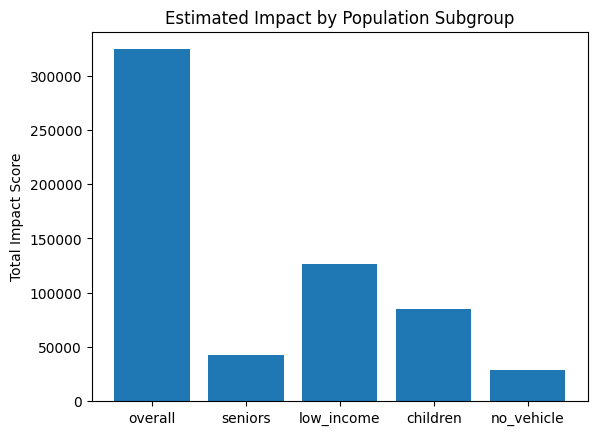

In [120]:
import matplotlib.pyplot as plt

plt.bar(impact_summary.keys(), impact_summary.values())
plt.ylabel('Total Impact Score')
plt.title('Estimated Impact by Population Subgroup')
plt.show()

Health data doesnt directly reflect the current health of the child population. Children living in tracts where adults exhibit high nutrition-sensitive disease burden and food access constraints may face elevated risk of poor nutritional environments. explains problem 3.

In [131]:

gdf['centroid'] = gdf.geometry.centroid
gdf['x'] = gdf.centroid.x
gdf['y'] = gdf.centroid.y


In [132]:
gdf.columns

Index(['place2010', 'tract2010', 'ST', 'PlaceName_x', 'plctract10',
       'PlcTrPop10', 'geometry', 'TractFIPS', 'PlaceFIPS', 'State',
       'PlaceName_y', 'Population2010', 'county_fips', 'PHLTH_CrudePrev',
       'OBESITY_CrudePrev', 'HIGHCHOL_CrudePrev', 'DIABETES_CrudePrev',
       'BPHIGH_CrudePrev', 'PCT_LACCESS_POP10', 'PCT_LACCESS_SENIORS10',
       'PCT_LACCESS_LOWI10', 'PCT_LACCESS_HHNV10', 'PCT_LACCESS_CHILD10',
       'LACCESS_POP10', 'LACCESS_SENIORS10', 'LACCESS_LOWI10',
       'LACCESS_HHNV10', 'LACCESS_CHILD10', 'health_index',
       'access_index_overall', 'access_index_seniors',
       'access_index_low_income', 'access_index_children',
       'access_index_no_vehicle', 'priority_index_overall',
       'priority_index_seniors', 'priority_index_low_income',
       'priority_index_children', 'priority_index_no_vehicle',
       'impact_score_overall', 'impact_score_seniors',
       'impact_score_low_income', 'impact_score_children',
       'impact_score_no_vehicle', '

/Users/nehabangalore/miniconda3/lib/python3.12/site-packages/matplotlib/collections.py:996: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


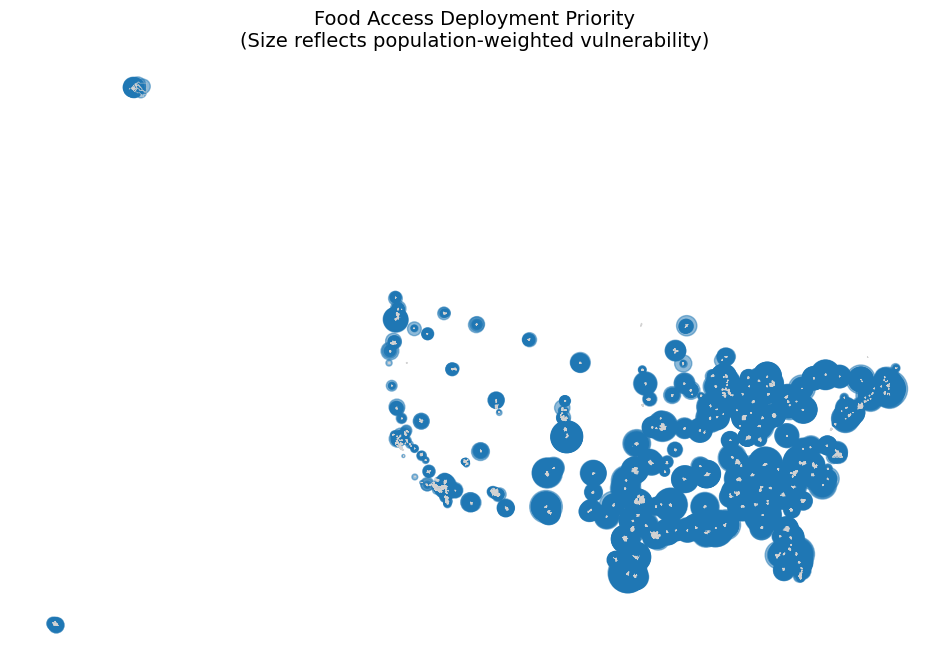

In [151]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 12))

# Base map
gdf.boundary.plot(ax=ax, linewidth=0.3, color='lightgrey')

# Deployment priority bubbles
ax.scatter(
    gdf['x'],
    gdf['y'],
    s=gdf['impact_score_overall'] / gdf['impact_score_overall'].max() * 800,
    alpha=0.5
)

ax.set_title(
    'Food Access Deployment Priority\n(Size reflects population-weighted vulnerability)',
    fontsize=14
)
ax.axis('off')
plt.show()


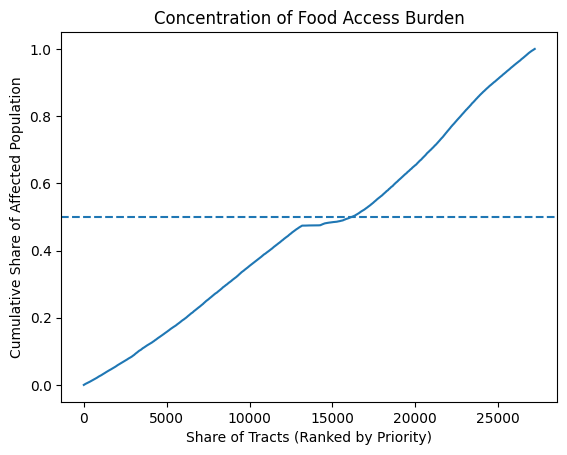

In [134]:
df_sorted = df_candidate.sort_values(
    'impact_score_overall', ascending=False
).reset_index(drop=True)

df_sorted['cum_population'] = df_sorted['LACCESS_POP10'].cumsum()
df_sorted['cum_pct_population'] = (
    df_sorted['cum_population'] /
    df_sorted['LACCESS_POP10'].sum()
)

plt.plot(df_sorted['cum_pct_population'])
plt.axhline(0.5, linestyle='--')
plt.xlabel('Share of Tracts (Ranked by Priority)')
plt.ylabel('Cumulative Share of Affected Population')
plt.title('Concentration of Food Access Burden')
plt.show()


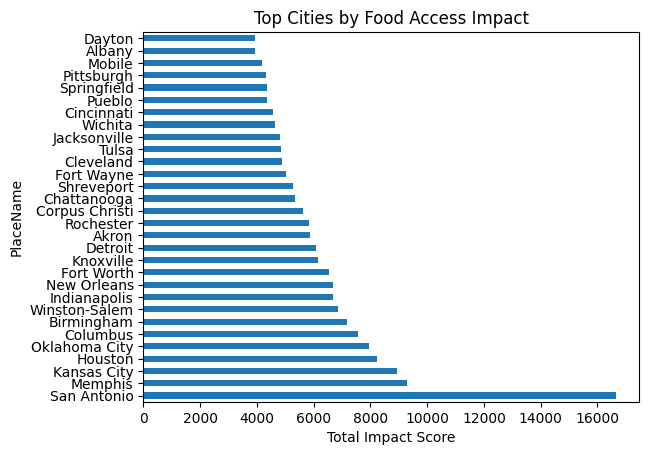

In [138]:
place_impact = (
    df_candidate
    .groupby('PlaceName')['impact_score_overall']
    .sum()
    .sort_values(ascending=False)
    .head(30)
)

place_impact.plot(kind='barh')
plt.title('Top Cities by Food Access Impact')
plt.xlabel('Total Impact Score')
plt.show()
#maybe we can start with 90% deployment tracts here as well. will do this for people count

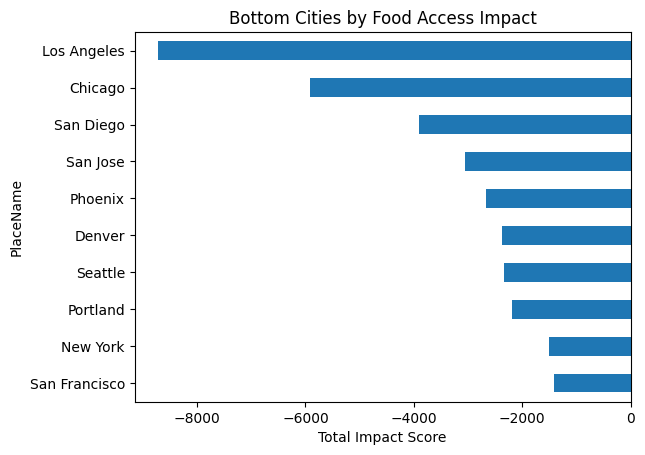

In [136]:
place_impact = (
    df_candidate
    .groupby('PlaceName')['impact_score_overall']
    .sum()
    .sort_values(ascending=False)
    .tail(10)
)

place_impact.plot(kind='barh')
plt.title('Bottom Cities by Food Access Impact')
plt.xlabel('Total Impact Score')
plt.show()

Here we can see where we should avoid. These cites either do not have proximity issues in high concentrations for food access, or their health issue index is lower.

In [139]:
threshold = df_candidate['impact_score_overall'].quantile(0.90)

df_candidate['deploy_flag'] = (
    df_candidate['impact_score_overall'] >= threshold
)

In [140]:
included_population = {
    'overall': df_candidate.loc[df_candidate['deploy_flag'], 'LACCESS_POP10'].sum(),
    'seniors': df_candidate.loc[df_candidate['deploy_flag'], 'LACCESS_SENIORS10'].sum(),
    'low_income': df_candidate.loc[df_candidate['deploy_flag'], 'LACCESS_LOWI10'].sum(),
    'children': df_candidate.loc[df_candidate['deploy_flag'], 'LACCESS_CHILD10'].sum(),
    'no_vehicle': df_candidate.loc[df_candidate['deploy_flag'], 'LACCESS_HHNV10'].sum()
}

included_population

{'overall': 473354854.86012673,
 'seniors': 55966020.27785198,
 'low_income': 148995425.35986954,
 'children': 121471929.81150956,
 'no_vehicle': 12465597.973526638}

We are going to make the assumption that engagement liklihood will increase where severity and scale overlap

In [142]:
engagement_share = {
    'overall': df_candidate.loc[df_candidate['deploy_flag'], 'impact_score_overall'].sum()
               / df_candidate['impact_score_overall'].sum(),

    'low_income': df_candidate.loc[df_candidate['deploy_flag'], 'impact_score_low_income'].sum()
               / df_candidate['impact_score_low_income'].sum(),

    'seniors': df_candidate.loc[df_candidate['deploy_flag'], 'impact_score_seniors'].sum()
               / df_candidate['impact_score_seniors'].sum(),
    'children': df_candidate.loc[df_candidate['deploy_flag'], 'impact_score_children'].sum()
               / df_candidate['impact_score_children'].sum(),
    'no_vehicle': df_candidate.loc[df_candidate['deploy_flag'], 'impact_score_no_vehicle'].sum()
               / df_candidate['impact_score_no_vehicle'].sum()
}

engagement_share


{'overall': 0.6983482119606897,
 'low_income': 0.6826161654985251,
 'seniors': 0.6877484927889512,
 'children': 0.6792709995043756,
 'no_vehicle': 0.6521326784670275}

In [143]:
projected_impact = {
    'overall': df_candidate.loc[df_candidate['deploy_flag'], 'impact_score_overall'].sum(),
    'low_income': df_candidate.loc[df_candidate['deploy_flag'], 'impact_score_low_income'].sum(),
    'children': df_candidate.loc[df_candidate['deploy_flag'], 'impact_score_children'].sum(),
    'seniors': df_candidate.loc[df_candidate['deploy_flag'], 'impact_score_seniors'].sum(),
    'no_vehicle': df_candidate.loc[df_candidate['deploy_flag'], 'impact_score_no_vehicle'].sum()
    
}

projected_impact


{'overall': 226515.00382031212,
 'low_income': 86146.53592546421,
 'children': 57594.30313972766,
 'seniors': 29373.31695946675,
 'no_vehicle': 18718.247135170262}

In [144]:
projected_impact_pct = {
    k: v / df_candidate[f'impact_score_{k}'].sum()
    for k, v in projected_impact.items()
}

projected_impact_pct


{'overall': 0.6983482119606897,
 'low_income': 0.6826161654985251,
 'children': 0.6792709995043756,
 'seniors': 0.6877484927889512,
 'no_vehicle': 0.6521326784670275}

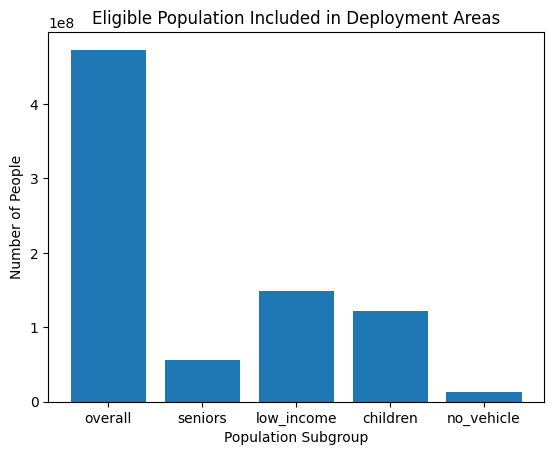

In [145]:


plt.figure()
plt.bar(included_population.keys(), included_population.values())
plt.title("Eligible Population Included in Deployment Areas")
plt.ylabel("Number of People")
plt.xlabel("Population Subgroup")
plt.show()


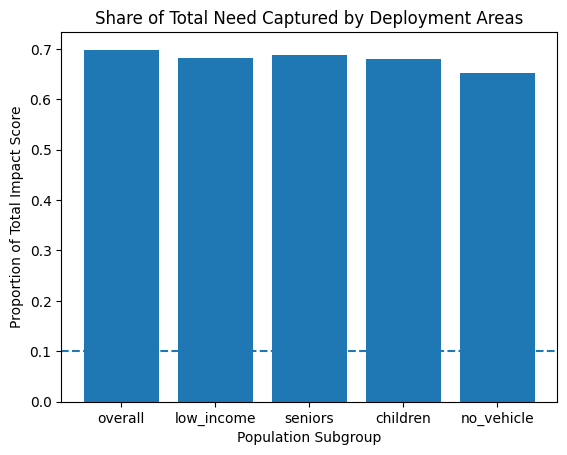

In [146]:
plt.figure()
plt.bar(engagement_share.keys(), engagement_share.values())
plt.axhline(0.10, linestyle='--')  # optional reference line
plt.title("Share of Total Need Captured by Deployment Areas")
plt.ylabel("Proportion of Total Impact Score")
plt.xlabel("Population Subgroup")
plt.show()


“Although we deploy to only 10% of tracts, we capture X–Y% of total food access need, suggesting strong engagement efficiency.”

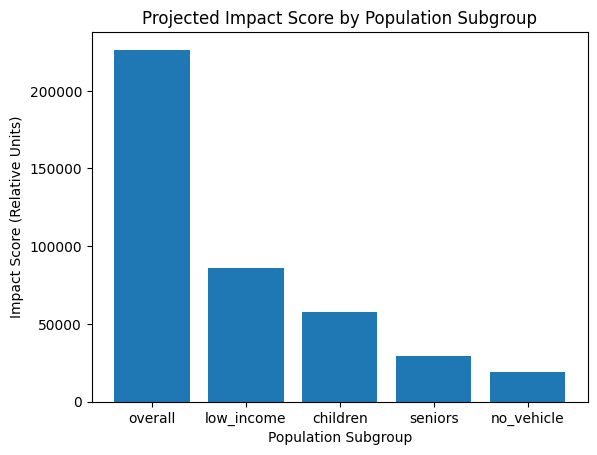

In [147]:
plt.figure()
plt.bar(projected_impact.keys(), projected_impact.values())
plt.title("Projected Impact Score by Population Subgroup")
plt.ylabel("Impact Score (Relative Units)")
plt.xlabel("Population Subgroup")
plt.show()


In [148]:

summary_df = pd.DataFrame({
    'subgroup': ['overall', 'low_income', 'children', 'seniors', 'no_vehicle'],
    'included_population': [
        included_population['overall'],
        included_population['low_income'],
        included_population['children'],
        included_population['seniors'],
        included_population['no_vehicle']
    ],
    'impact_pct': [
        projected_impact_pct['overall'],
        projected_impact_pct['low_income'],
        projected_impact_pct['children'],
        projected_impact_pct['seniors'],
        projected_impact_pct['no_vehicle']
    ],
    'impact_abs': [
        projected_impact['overall'],
        projected_impact['low_income'],
        projected_impact['children'],
        projected_impact['seniors'],
        projected_impact['no_vehicle']
    ]
})


In [152]:
plot_df = summary_df[summary_df['subgroup'] != 'overall']


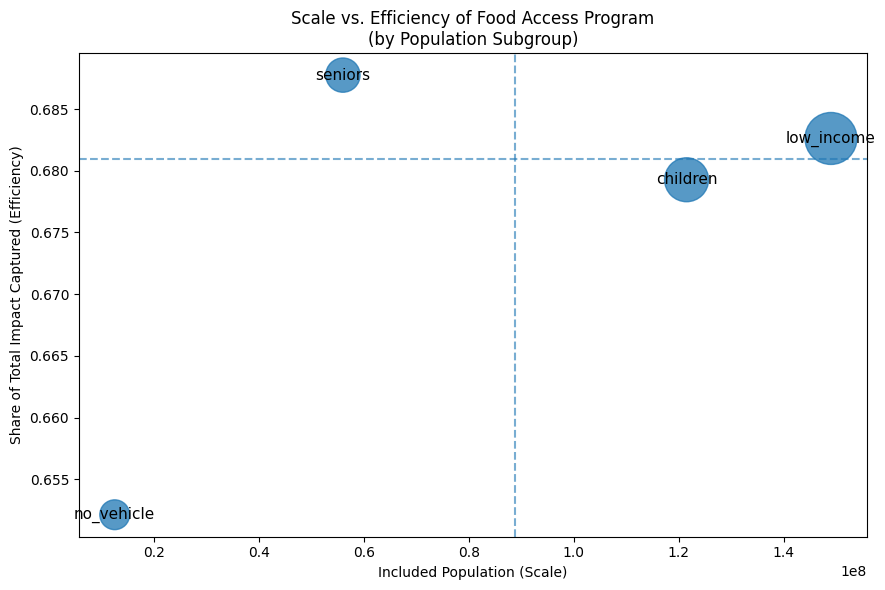

In [154]:
import matplotlib.pyplot as plt

plt.figure(figsize=(9, 6))

plt.scatter(
    plot_df['included_population'],
    plot_df['impact_pct'],
    s=plot_df['impact_abs'] / plot_df['impact_abs'].max() * 1200 + 200,
    alpha=0.75
)

# Label each point
for _, row in plot_df.iterrows():
    plt.text(
        row['included_population'],
        row['impact_pct'],
        row['subgroup'],
        fontsize=11,
        ha='center',
        va='center'
    )

# Median reference lines (now meaningful)
plt.axvline(plot_df['included_population'].median(), linestyle='--', alpha=0.6)
plt.axhline(plot_df['impact_pct'].median(), linestyle='--', alpha=0.6)

plt.xlabel("Included Population (Scale)")
plt.ylabel("Share of Total Impact Captured (Efficiency)")
plt.title("Scale vs. Efficiency of Food Access Program\n(by Population Subgroup)")

plt.tight_layout()
plt.show()


In [157]:
counties = gpd.read_file("tl_2010_us_county10/tl_2010_us_county10.shp")
counties.head()

,STATEFP10,COUNTYFP10,COUNTYNS10,GEOID10,NAME10,NAMELSAD10,LSAD10,CLASSFP10,MTFCC10,CSAFP10,CBSAFP10,METDIVFP10,FUNCSTAT10,ALAND10,AWATER10,INTPTLAT10,INTPTLON10,geometry
0,02,013,01419964,02013,Aleutians East,Aleutians East Borough,04,H1,G4020,None,None,None,A,18083148800,20792209033,+55.2437223,-161.9507485,"MULTIPOLYGON (((-162.63769 54.80112, -162.6411..."
1,02,016,01419965,02016,Aleutians West,Aleutians West Census Area,05,H5,G4020,None,None,None,S,11370762625,25190643524,+51.9594469,+178.3388130,"MULTIPOLYGON (((177.44593 52.11133, 177.44302 ..."
2,28,107,00695776,28107,Panola,Panola County,06,H1,G4020,None,None,None,A,1774515519,51767046,+34.3652052,-089.9630654,"POLYGON ((-90.13476 34.22603, -90.13476 34.226..."
3,28,101,00695773,28101,Newton,Newton County,06,H1,G4020,None,None,None,A,1497282694,3879399,+32.4019702,-089.1184115,"POLYGON ((-89.13497 32.57697, -89.13466 32.576..."
4,28,027,00695738,28027,Coahoma,Coahoma County,06,H1,G4020,None,17260,None,A,1430818231,79539470,+34.2286699,-090.6031650,"POLYGON ((-90.59062 33.9869, -90.59473 33.9869..."


In [158]:
counties.shape

(3221, 18)

In [159]:
counties.columns

Index(['STATEFP10', 'COUNTYFP10', 'COUNTYNS10', 'GEOID10', 'NAME10',
       'NAMELSAD10', 'LSAD10', 'CLASSFP10', 'MTFCC10', 'CSAFP10', 'CBSAFP10',
       'METDIVFP10', 'FUNCSTAT10', 'ALAND10', 'AWATER10', 'INTPTLAT10',
       'INTPTLON10', 'geometry'],
      dtype='object')

In [160]:
food_atlas.columns

Index(['index', 'FIPS', 'State', 'County', 'LACCESS_POP10', 'LACCESS_POP15',
       'PCH_LACCESS_POP_10_15', 'PCT_LACCESS_POP10', 'PCT_LACCESS_POP15',
       'LACCESS_LOWI10', 'LACCESS_LOWI15', 'PCH_LACCESS_LOWI_10_15',
       'PCT_LACCESS_LOWI10', 'PCT_LACCESS_LOWI15', 'LACCESS_HHNV10',
       'LACCESS_HHNV15', 'PCH_LACCESS_HHNV_10_15', 'PCT_LACCESS_HHNV10',
       'PCT_LACCESS_HHNV15', 'LACCESS_SNAP15', 'PCT_LACCESS_SNAP15',
       'LACCESS_CHILD10', 'LACCESS_CHILD15', 'LACCESS_CHILD_10_15',
       'PCT_LACCESS_CHILD10', 'PCT_LACCESS_CHILD15', 'LACCESS_SENIORS10',
       'LACCESS_SENIORS15', 'PCH_LACCESS_SENIORS_10_15',
       'PCT_LACCESS_SENIORS10', 'PCT_LACCESS_SENIORS15', 'LACCESS_WHITE15',
       'PCT_LACCESS_WHITE15', 'LACCESS_BLACK15', 'PCT_LACCESS_BLACK15',
       'LACCESS_HISP15', 'PCT_LACCESS_HISP15', 'LACCESS_NHASIAN15',
       'PCT_LACCESS_NHASIAN15', 'LACCESS_NHNA15', 'PCT_LACCESS_NHNA15',
       'LACCESS_NHPI15', 'PCT_LACCESS_NHPI15', 'LACCESS_MULTIR15',
       'PCT_LAC

In [161]:
counties = counties.rename(columns={'GEOID10': 'county_fips'})
counties['county_fips'] = counties['county_fips'].astype(str)


In [162]:
county_gdf = counties.merge(
    food_atlas,
    on='county_fips',
    how='left'
)


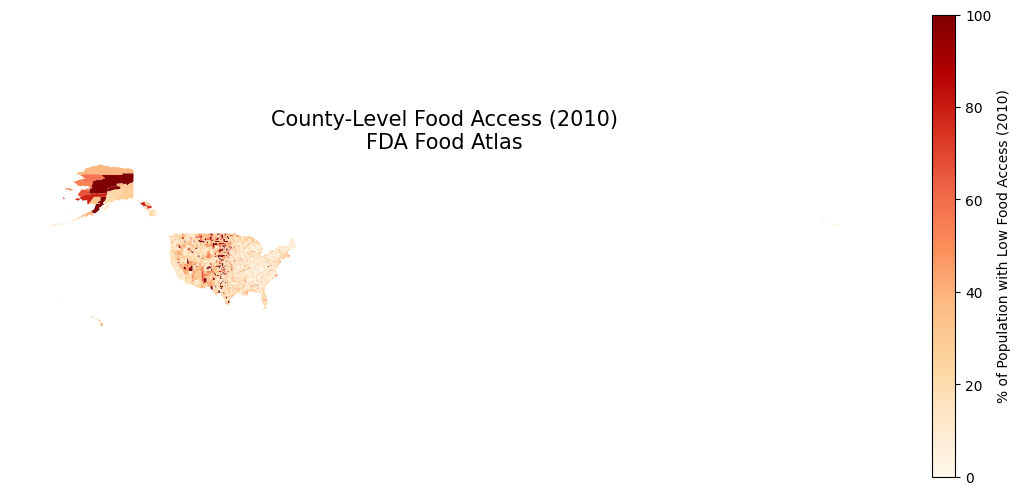

In [163]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(14, 10))

county_gdf.plot(
    column='PCT_LACCESS_POP10',
    cmap='OrRd',
    linewidth=0.2,
    ax=ax,
    legend=True,
    legend_kwds={
        'label': '% of Population with Low Food Access (2010)',
        'shrink': 0.6
    }
)

ax.set_title(
    'County-Level Food Access (2010)\nFDA Food Atlas',
    fontsize=15
)

ax.axis('off')
plt.show()


In [164]:
mainland = county_gdf[
    ~county_gdf['STATEFP10'].isin(['02', '15', '60', '66', '69', '72', '78'])
]

alaska = county_gdf[county_gdf['STATEFP10'] == '02']
hawaii = county_gdf[county_gdf['STATEFP10'] == '15']


In [165]:
vmin = county_gdf['PCT_LACCESS_POP10'].min()
vmax = county_gdf['PCT_LACCESS_POP10'].max()


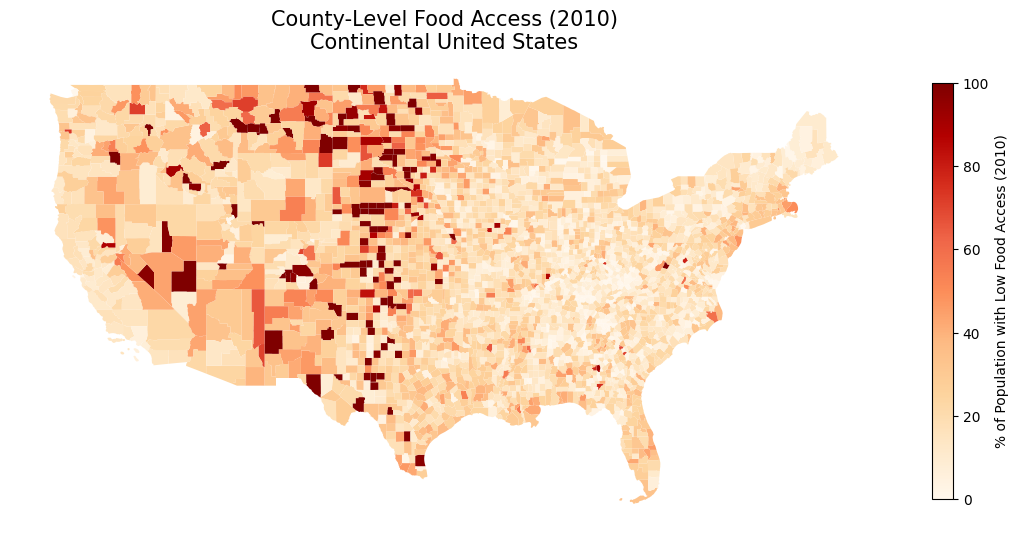

In [166]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(14, 9))

mainland.plot(
    column='PCT_LACCESS_POP10',
    cmap='OrRd',
    linewidth=0.2,
    ax=ax,
    vmin=vmin,
    vmax=vmax,
    legend=True,
    legend_kwds={
        'label': '% of Population with Low Food Access (2010)',
        'shrink': 0.6
    }
)

ax.set_title('County-Level Food Access (2010)\nContinental United States', fontsize=15)
ax.axis('off')
plt.show()


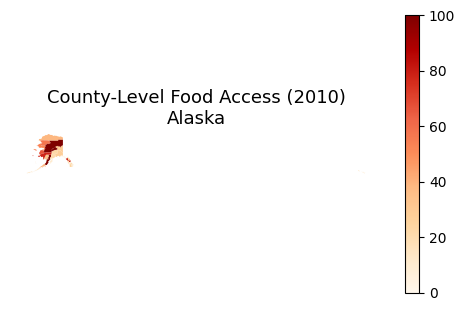

In [167]:
fig, ax = plt.subplots(figsize=(6, 6))

alaska.plot(
    column='PCT_LACCESS_POP10',
    cmap='OrRd',
    linewidth=0.2,
    ax=ax,
    vmin=vmin,
    vmax=vmax,
    legend=True,
    legend_kwds={'shrink': 0.6}
)

ax.set_title('County-Level Food Access (2010)\nAlaska', fontsize=13)
ax.axis('off')
plt.show()


In [170]:
def center_map(gdf, ax, pad=0.05):
    minx, miny, maxx, maxy = gdf.total_bounds
    dx = maxx - minx
    dy = maxy - miny

    ax.set_xlim(minx - pad * dx, maxx + pad * dx)
    ax.set_ylim(miny - pad * dy, maxy + pad * dy)


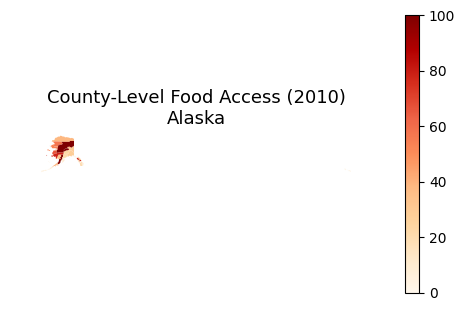

In [172]:
fig, ax = plt.subplots(figsize=(6, 6))

alaska.plot(
    column='PCT_LACCESS_POP10',
    cmap='OrRd',
    linewidth=0.2,
    ax=ax,
    vmin=vmin,
    vmax=vmax,
    legend=True,
    legend_kwds={'shrink': 0.6}
)

center_map(alaska, ax, pad=0.1)

ax.set_title("County-Level Food Access (2010)\nAlaska", fontsize=13)
ax.axis('off')
plt.show()


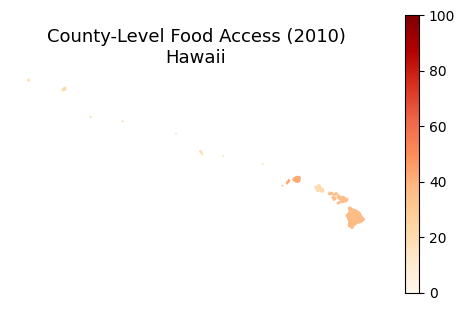

In [168]:
fig, ax = plt.subplots(figsize=(6, 6))

hawaii.plot(
    column='PCT_LACCESS_POP10',
    cmap='OrRd',
    linewidth=0.2,
    ax=ax,
    vmin=vmin,
    vmax=vmax,
    legend=True,
    legend_kwds={'shrink': 0.6}
)

ax.set_title('County-Level Food Access (2010)\nHawaii', fontsize=13)
ax.axis('off')
plt.show()


somehow use an alluvial graph to show flow of counties level of food access befroe and after the program

In [174]:
tract_gdf = gdf

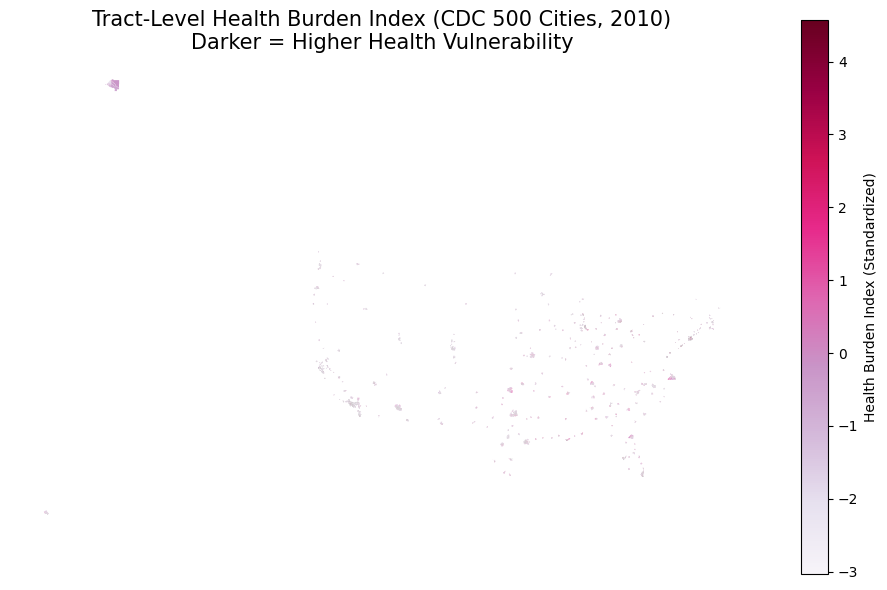

In [175]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 12))

tract_gdf.plot(
    column='health_index',
    cmap='PuRd',
    linewidth=0,
    ax=ax,
    legend=True,
    legend_kwds={
        'label': 'Health Burden Index (Standardized)',
        'shrink': 0.6
    }
)

# Optional boundaries for spatial context
tract_gdf.boundary.plot(
    ax=ax,
    linewidth=0.1,
    color='white',
    alpha=0.3
)

ax.set_title(
    "Tract-Level Health Burden Index (CDC 500 Cities, 2010)\nDarker = Higher Health Vulnerability",
    fontsize=15
)

ax.axis('off')
plt.show()
